# Predecir nivel de adaptabilidad

In [14]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv

import tensorflow as tf

from tensorflow import keras
from keras import layers
from sklearn.preprocessing import OneHotEncoder

print(tf.__version__)

2.14.0


## Exploracion de los datos
The data is obtained from the csv file "training-ds"

In [15]:
raw_dataset = pd.read_csv("./training-ds.csv")
dataset = raw_dataset.copy()
raw_dataset.head()


,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,03-Jun,Bajo
1,3G,No,Escuela,Si,Privado,Nov-15,Smartphone,Compra Megas,Media,Femenino,01-Mar,Moderado
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,01-Mar,Bajo
3,3G,Si,Escuela,Si,Privado,Nov-15,Smartphone,Compra Megas,Media,Masculino,01-Mar,Moderado
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,01-Mar,Alto


### Cleaning Data

If the dataset contains any unknown value the row containing it will be deleted

In [16]:
dataset.isna().sum()

Tipo de Red                 0
Estudiante de Tecnología    0
Nivel de Educación          0
Vive en Ciudad              0
Tipo de Instituto           0
Edad                        0
Dispositivo                 0
Tipo de Internet            0
Situación Financiera        0
Género                      0
Duración de la Clase        0
Nivel de Adaptación         0
dtype: int64

As the dataset does not contain any unknown values, no row will be deleted.

### Correcting the data
The "Edad" column should contain values that indicate an age interval following this format: "21-24". 
But there are values that changed the value of a limit for a month like this: "Nov-15"

The data is corrected using the "correct_age" function.

In [17]:
def correct_number(edad): 
    months = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 
             'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

    for m in months: 
        if m in edad: 
            return edad.replace(m, months[m]) 
        
    return edad

This function is applied to the "Edad" column.

In [18]:
dataset['Edad'] = dataset["Edad"].apply(correct_number)
dataset.head()

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,03-Jun,Bajo
1,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,01-Mar,Moderado
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,01-Mar,Bajo
3,3G,Si,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Masculino,01-Mar,Moderado
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,01-Mar,Alto


Same as the "Edad" column the "Duracion de la clase" column has the number values changed. 
The same function is applied to this column

In [19]:
dataset['Duración de la Clase'] = dataset["Duración de la Clase"].apply(correct_number)
dataset.head()

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,03-06,Bajo
1,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,01-03,Moderado
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,01-03,Bajo
3,3G,Si,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Masculino,01-03,Moderado
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,01-03,Alto


### One hot encoding

In [20]:
#Tipo de red
dataset['Tipo de Red'].nunique()

3

In [21]:
def one_hot_encoding(colum, val, ds):
    lst =[]
    for elem in ds[colum]:
        if(elem == val):
            lst.append(1)
        else:
            lst.append(0)
    return lst

In [22]:
# four_g=one_hot_encoding('Tipo de Red','4G')
# three_g=one_hot_encoding('Tipo de Red','3G')
# two_g=one_hot_encoding('Tipo de Red','2G')

In [23]:
# dataset.insert(1, "G4", four_g, True)
# dataset.insert(1, "G3", three_g, True)
# dataset.insert(1, "G2", two_g, True)
# dataset.drop(columns=['Tipo de Red'])
#dataset['Estudiante de Tecnología'].unique()

In [24]:
dataset.columns.values

array(['Tipo de Red', 'Estudiante de Tecnología', 'Nivel de Educación',
       'Vive en Ciudad', 'Tipo de Instituto', 'Edad', 'Dispositivo',
       'Tipo de Internet', 'Situación Financiera', 'Género',
       'Duración de la Clase', 'Nivel de Adaptación'], dtype=object)

In [28]:
def hot_one_dataset(ds):
    new_dataset=pd.DataFrame()
    for i in ds.columns.values:
        if(len(ds[i].unique())>2):
            for j in ds[i].unique():
                new_dataset.insert(0, str(i+" "+j), one_hot_encoding(i, j, ds), True)
        else:
            new_dataset.insert(0, str(i), one_hot_encoding(i, ds[i].unique()[0], ds), True)
    return new_dataset

In [29]:
# tags=dataset.pop('Nivel de Adaptación')
encoded_dataset=hot_one_dataset(dataset)
encoded_dataset

,Nivel de Adaptación Alto,Nivel de Adaptación Moderado,Nivel de Adaptación Bajo,Duración de la Clase 0,Duración de la Clase 01-03,Duración de la Clase 03-06,Género,Situación Financiera Buena,Situación Financiera Mala,Situación Financiera Media,...,Edad 21-25,Tipo de Instituto,Vive en Ciudad,Nivel de Educación Colegio,Nivel de Educación Escuela,Nivel de Educación Universidad,Estudiante de Tecnología,Tipo de Red 2G,Tipo de Red 4G,Tipo de Red 3G
0,0,0,1,0,0,1,1,0,0,1,...,1,1,1,0,0,1,1,0,0,1
1,0,1,0,0,1,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,1
2,0,0,1,0,1,0,1,0,1,0,...,1,1,1,0,0,1,1,0,0,1
3,0,1,0,0,1,0,1,0,0,1,...,0,1,1,0,1,0,1,0,0,1
4,1,0,0,0,1,0,1,1,0,0,...,1,1,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,0,1,0,0,1,0,1,0,0,1,...,1,1,1,0,0,1,0,0,0,1
960,0,1,0,0,1,0,0,0,0,1,...,0,1,1,0,1,0,0,0,0,1
961,0,0,1,1,0,0,1,0,0,1,...,1,0,1,0,0,1,0,0,1,0
962,0,1,0,0,1,0,1,0,0,1,...,1,1,1,0,0,1,0,0,0,1


In [30]:
encoded_dataset.columns.values

array(['Nivel de Adaptación Alto', 'Nivel de Adaptación Moderado',
       'Nivel de Adaptación Bajo', 'Duración de la Clase 0',
       'Duración de la Clase 01-03', 'Duración de la Clase 03-06',
       'Género', 'Situación Financiera Buena',
       'Situación Financiera Mala', 'Situación Financiera Media',
       'Tipo de Internet', 'Dispositivo Tableta',
       'Dispositivo Smartphone', 'Dispositivo Computadora', 'Edad 06-10',
       'Edad 01-05', 'Edad 26-30', 'Edad 16-20', 'Edad 11-15',
       'Edad 21-25', 'Tipo de Instituto', 'Vive en Ciudad',
       'Nivel de Educación Colegio', 'Nivel de Educación Escuela',
       'Nivel de Educación Universidad', 'Estudiante de Tecnología',
       'Tipo de Red 2G', 'Tipo de Red 4G', 'Tipo de Red 3G'], dtype=object)

In [31]:
def plot_pies(dataset):
    display=len(dataset.columns.values)
    fig, axes = plt.subplots(3,4,figsize=(10, 10))
    fig.subplots_adjust(wspace=.5)
    counter=0
    x=(0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2)
    z=(0, 1, 2, 3, 0, 1, 2, 3, 0, 1 ,2 ,3)
    for i in dataset.columns.values:
            val1=x[counter]
            val2=z[counter]
            y=dataset.pivot_table(index = [i], aggfunc ='size')
            axes[val1][val2].pie(y, labels =list(y.keys()))
            axes[val1][val2].set_title(i, fontsize = 12)
            counter=counter+1
    plt.show()


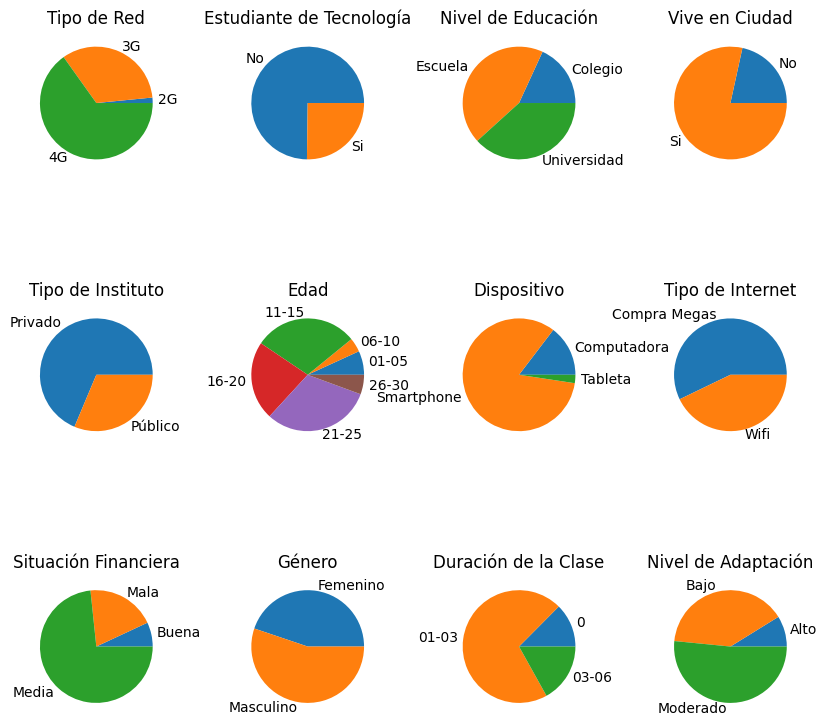

In [32]:
#encoded_dataset.plot.pie(y='Género', figsize=(5, 5))

plot_pies(dataset)

In [33]:
dataset.pivot_table(index = ['Tipo de Instituto'], aggfunc ='size')

Tipo de Instituto
Privado    662
Público    302
dtype: int64

In [34]:
correlation_matrix = encoded_dataset.corr()
correlations = correlation_matrix.loc[['Nivel de Adaptación Alto', "Nivel de Adaptación Moderado", "Nivel de Adaptación Bajo"]]
correlations = correlations.transpose()
correlations = correlations.drop(['Nivel de Adaptación Alto', "Nivel de Adaptación Moderado", "Nivel de Adaptación Bajo"])
correlations

,Nivel de Adaptación Alto,Nivel de Adaptación Moderado,Nivel de Adaptación Bajo
Duración de la Clase 0,-0.117813,-0.334453,0.410024
Duración de la Clase 01-03,0.072560,0.106634,-0.151017
Duración de la Clase 03-06,0.015886,0.165930,-0.178748
Género,0.103664,0.003014,-0.063174
Situación Financiera Buena,0.389750,-0.069726,-0.154700
Situación Financiera Mala,0.011467,-0.130219,0.126404
Situación Financiera Media,-0.234469,0.157252,-0.024748
Tipo de Internet,0.122606,-0.020664,-0.049963
Dispositivo Tableta,-0.024644,0.124345,-0.112763
Dispositivo Smartphone,-0.122091,-0.090864,0.163617


In [35]:
correlations['mean'] = correlations[['Nivel de Adaptación Alto', "Nivel de Adaptación Moderado", "Nivel de Adaptación Bajo"]].abs().mean(axis=1)
correlations = correlations[correlations['mean'] >= 0.10]
correlations

,Nivel de Adaptación Alto,Nivel de Adaptación Moderado,Nivel de Adaptación Bajo,mean
Duración de la Clase 0,-0.117813,-0.334453,0.410024,0.287430
Duración de la Clase 01-03,0.072560,0.106634,-0.151017,0.110071
Duración de la Clase 03-06,0.015886,0.165930,-0.178748,0.120188
Situación Financiera Buena,0.389750,-0.069726,-0.154700,0.204725
Situación Financiera Media,-0.234469,0.157252,-0.024748,0.138823
Dispositivo Smartphone,-0.122091,-0.090864,0.163617,0.125524
Dispositivo Computadora,0.140463,0.042915,-0.125276,0.102885
Edad 06-10,0.158966,-0.148617,0.059694,0.122426
Edad 01-05,-0.084304,0.139505,-0.093667,0.105825
Edad 16-20,-0.124376,-0.071411,0.145066,0.113618


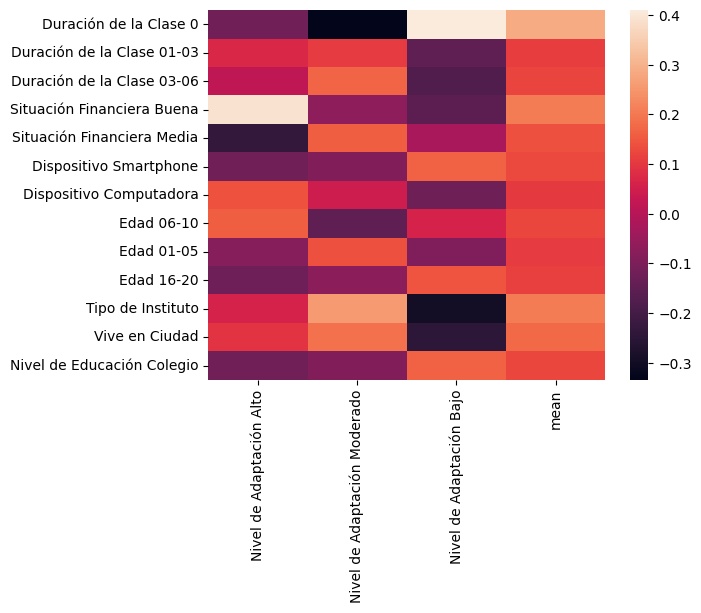

In [36]:

sns.heatmap(correlations, annot=False)
plt.show()

La poca cantidad de cantidad puede generar BIAS

In [37]:
# dataset['Tipo de Red'] 
dataset.loc[dataset['Tipo de Red'] == '2G']

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
220,2G,No,Universidad,Si,Privado,21-25,Smartphone,Wifi,Media,Femenino,03-06,Moderado
285,2G,No,Escuela,No,Público,11-15,Smartphone,Compra Megas,Mala,Femenino,01-03,Bajo
339,2G,No,Escuela,Si,Privado,06-10,Smartphone,Compra Megas,Media,Femenino,01-03,Bajo
383,2G,Si,Universidad,No,Privado,21-25,Tableta,Wifi,Mala,Femenino,03-06,Bajo
441,2G,No,Escuela,No,Público,06-10,Smartphone,Compra Megas,Media,Masculino,0,Bajo
442,2G,No,Universidad,No,Público,21-25,Smartphone,Compra Megas,Media,Femenino,01-03,Bajo
453,2G,No,Escuela,Si,Privado,06-10,Smartphone,Compra Megas,Media,Femenino,01-03,Bajo
455,2G,No,Escuela,No,Público,06-10,Smartphone,Compra Megas,Media,Masculino,0,Bajo
536,2G,No,Colegio,No,Público,16-20,Smartphone,Compra Megas,Mala,Masculino,01-03,Bajo
641,2G,No,Escuela,No,Público,11-15,Smartphone,Compra Megas,Mala,Femenino,01-03,Bajo


In [38]:
#cuan
dataset_one_hot= dataset.copy(); 
labels = dataset_one_hot.pop('Nivel de Adaptación')
dict = {"Bajo": 0, "Moderado": 1, "Alto": 2}
enconded_labels = []
for label in labels: 
    enconded_labels.append(dict[label])
enconded_labels = np.array(enconded_labels)

final_dataset = hot_one_dataset(dataset_one_hot)
final_dataset.insert(0, "label", enconded_labels, True)
final_dataset

,label,Duración de la Clase 0,Duración de la Clase 01-03,Duración de la Clase 03-06,Género,Situación Financiera Buena,Situación Financiera Mala,Situación Financiera Media,Tipo de Internet,Dispositivo Tableta,...,Edad 21-25,Tipo de Instituto,Vive en Ciudad,Nivel de Educación Colegio,Nivel de Educación Escuela,Nivel de Educación Universidad,Estudiante de Tecnología,Tipo de Red 2G,Tipo de Red 4G,Tipo de Red 3G
0,0,0,0,1,1,0,0,1,1,0,...,1,1,1,0,0,1,1,0,0,1
1,1,0,1,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,0,0,1
2,0,0,1,0,1,0,1,0,0,0,...,1,1,1,0,0,1,1,0,0,1
3,1,0,1,0,1,0,0,1,0,0,...,0,1,1,0,1,0,1,0,0,1
4,2,0,1,0,1,1,0,0,1,0,...,1,1,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,1,0,1,0,1,0,0,1,0,0,...,1,1,1,0,0,1,0,0,0,1
960,1,0,1,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,0,0,1
961,0,1,0,0,1,0,0,1,0,0,...,1,0,1,0,0,1,0,0,1,0
962,1,0,1,0,1,0,0,1,0,0,...,1,1,1,0,0,1,0,0,0,1


In [39]:
final_dataset.head(15)

,label,Duración de la Clase 0,Duración de la Clase 01-03,Duración de la Clase 03-06,Género,Situación Financiera Buena,Situación Financiera Mala,Situación Financiera Media,Tipo de Internet,Dispositivo Tableta,...,Edad 21-25,Tipo de Instituto,Vive en Ciudad,Nivel de Educación Colegio,Nivel de Educación Escuela,Nivel de Educación Universidad,Estudiante de Tecnología,Tipo de Red 2G,Tipo de Red 4G,Tipo de Red 3G
0,0,0,0,1,1,0,0,1,1,0,...,1,1,1,0,0,1,1,0,0,1
1,1,0,1,0,0,0,0,1,0,0,...,0,1,1,0,1,0,0,0,0,1
2,0,0,1,0,1,0,1,0,0,0,...,1,1,1,0,0,1,1,0,0,1
3,1,0,1,0,1,0,0,1,0,0,...,0,1,1,0,1,0,1,0,0,1
4,2,0,1,0,1,1,0,0,1,0,...,1,1,1,0,0,1,1,0,1,0
5,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
6,1,0,1,0,1,0,0,1,0,0,...,0,1,1,0,1,0,1,0,1,0
7,1,0,1,0,1,0,0,1,0,0,...,0,1,1,0,1,0,0,0,0,1
8,2,0,1,0,1,0,1,0,0,0,...,1,1,1,0,0,1,0,0,1,0
9,1,0,1,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,1,0


In [40]:
train_dataset = final_dataset.sample(frac=0.8,random_state=0)
test_dataset = final_dataset.drop(train_dataset.index)

In [41]:
labels_train = train_dataset.pop('label')
labels_train = labels_train.to_numpy()
ready2train = train_dataset.to_numpy()

labels_test = test_dataset.pop('label')
labels_test = labels_test.to_numpy()
ready2test = test_dataset.to_numpy()

In [42]:
print(ready2train)
print(ready2train.shape)
print(labels_train)

print(ready2test)
print(ready2test.shape)
print(labels_test)

[[0 1 0 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 [1 0 0 ... 0 1 0]
 ...
 [0 0 1 ... 0 1 0]
 [0 1 0 ... 0 1 0]
 [0 1 0 ... 0 0 1]]
(771, 26)
[0 0 0 1 1 0 0 1 2 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 2 0 1 0 2 0 0 0 2 1 2
 1 1 1 0 0 0 1 0 1 1 1 2 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1 1 2 1 1 2 1 0 1 0 0
 2 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 2 0 0 1 2 1 1 0 0 0 0
 1 1 2 1 0 1 1 1 2 1 1 1 2 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 0 2 0 0 1 0 0
 1 0 1 1 1 1 0 2 1 1 1 0 0 1 1 0 1 1 2 2 0 1 1 1 0 2 0 1 0 0 0 1 0 1 2 2 1
 0 0 1 0 1 0 0 0 1 2 0 0 1 1 1 1 0 0 0 2 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 1 2 0 1 1 1 0 0 0 0 2 1 1 1 0 1 0 0 0 1 1 1 2 1 1 1 0 2 0 1 1 1 1 1
 0 2 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 2 1 0 1 1 1 2 1 0 2 1 1 0 1
 2 1 1 0 0 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 2 0 0 1 0 1 1 1 0 1 0 1 0 0 0 1 0
 1 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 2 0 2 1 1 0 1
 1 1 2 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0
 0 0 1 0 0 0 1 1 1 2 0 1 1 1 2 0 1 1 0 1 0 1 

# Models

Construir el modelo

In [43]:
def getModel(first_layer, second_layer, activation_fun, optimizer_opt): 
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(26,)))
    model.add(tf.keras.layers.Dense(first_layer, activation=activation_fun))
    model.add(tf.keras.layers.Dense(second_layer, activation=activation_fun))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer=optimizer_opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    return model

In [44]:

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.ylim([0,1])
    plt.legend()
    plt.show()

In [45]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(26,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
# tambien podemos utilizar softplus
# al parecer relu no se lleva bien con muchas neuronas o muhas capas 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

2023-11-25 10:22:08.718440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-25 10:22:08.752440: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/150
25/25 [==============================] - 2s 13ms/step - loss: 0.9020 - accuracy: 0.5785 - val_loss: 0.7515 - val_accuracy: 0.6269
Epoch 2/150
25/25 [==============================] - 0s 4ms/step - loss: 0.7705 - accuracy: 0.6368 - val_loss: 0.6592 - val_accuracy: 0.7150
Epoch 3/150
25/25 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.7056 - val_loss: 0.6113 - val_accuracy: 0.7254
Epoch 4/150
25/25 [==============================] - 0s 4ms/step - loss: 0.6037 - accuracy: 0.7432 - val_loss: 0.5897 - val_accuracy: 0.7098
Epoch 5/150
25/25 [==============================] - 0s 4ms/step - loss: 0.5455 - accuracy: 0.7601 - val_loss: 0.5986 - val_accuracy: 0.6891
Epoch 6/150
25/25 [==============================] - 0s 4ms/step - loss: 0.5436 - accuracy: 0.7510 - val_loss: 0.6206 - val_accuracy: 0.7565
Epoch 7/150
25/25 [==============================] - 0s 4ms/step - loss: 0.4527 - accuracy: 0.8145 - val_loss: 0.5727 - val_accuracy: 0.7824
Epoch 8/150


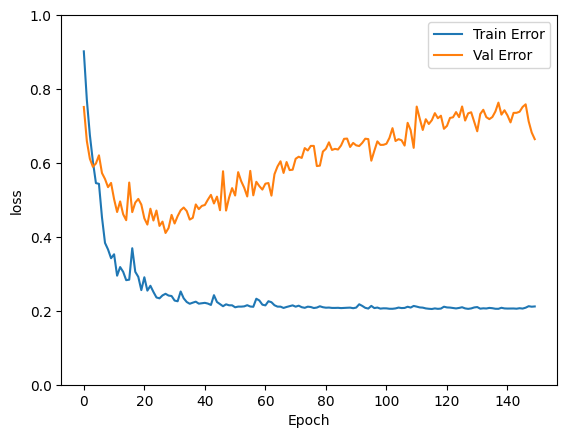

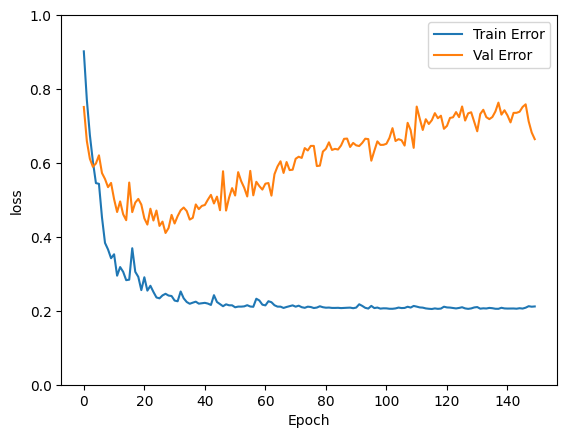

7/7 - 0s - loss: 0.6644 - accuracy: 0.8549 - 31ms/epoch - 4ms/step

Test accuracy: 0.8549222946166992


In [46]:
hist = model.fit(ready2train, labels_train, validation_data=(ready2test, labels_test), epochs = 150)
plot_history(hist)

test_loss, test_acc = model.evaluate(ready2test, labels_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [47]:
test_loss, test_acc = model.evaluate(ready2test,  labels_test, verbose=2)
print('\nTest accuracy:', test_acc)

7/7 - 0s - loss: 0.6644 - accuracy: 0.8549 - 38ms/epoch - 5ms/step

Test accuracy: 0.8549222946166992


In [53]:
map_dict = {0: 'Bajo', 1: 'Moderado', 2: 'Alto'}

def mapper(lst):
  return list(map(lambda x: map_dict[x], lst))

sub_dataset = pd.read_csv('./training-ds.csv')
sub_dataset['Edad'] = dataset["Edad"].apply(correct_number)
sub_dataset['Duración de la Clase'] = sub_dataset["Duración de la Clase"].apply(correct_number)
sub_dataset.pop('Nivel de Adaptación')

sub_dataset = hot_one_dataset(sub_dataset)
sub_dataset

sub_x = sub_dataset.to_numpy()
sub_x

sub_predictions = model.predict(sub_x)

31/31 [==============================] - 0s 2ms/step


In [54]:
indices = []
for pred in sub_predictions:
  indices.append(np.argmax(pred))

predicted_labels = mapper(indices)
my_list = [["id", "Nivel de Adaptación"]]
for i in range(len(predicted_labels)):
  my_list.append([i+1, predicted_labels[i]])
  with open('tangente_128x128.csv', 'w', newline='') as file:
    # Step 4: Using csv.writer to write the list to the CSV file
    writer = csv.writer(file)
    writer.writerows(my_list) # Use writerows for nested list

In [32]:
# El modelo: 
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(26,)))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dense(3, activation='softmax'))

# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# con 200 epochs
# obtinene: 0.8549222946166992 de accuracy

In [34]:
models = []
1
activations = ['relu', 'leaky_relu', 'tanh']
optimizers = ["RMSprop", "Adam", "Nadam"]
for act in activations: 
    model0 = getModel(64, 64, act) 
    model1 = getModel(128, 128, act)
    model2 = getModel(128, 64, act)
    model3 = getModel(64, 128, act)

    models.append(model0)
    models.append(model1)
    models.append(model2)
    models.append(model3)

accus = []
i = 1
for model in models: 
    model.fit(ready2train, labels_train,validation_data = (ready2test, labels_test), epochs = 200)
    test_loss, test_acc = model.evaluate(ready2test,  labels_test, verbose=2)
    accus.append(test_acc)


    

Epoch 1/200
25/25 [==============================] - 1s 7ms/step - loss: 0.9895 - accuracy: 0.5058 - val_loss: 0.8223 - val_accuracy: 0.6269
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 0.8667 - accuracy: 0.5966 - val_loss: 0.7608 - val_accuracy: 0.6632
Epoch 3/200
25/25 [==============================] - 0s 3ms/step - loss: 0.8002 - accuracy: 0.6667 - val_loss: 0.7218 - val_accuracy: 0.6891
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7456 - accuracy: 0.6783 - val_loss: 0.6912 - val_accuracy: 0.6632
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 0.7016 - accuracy: 0.7082 - val_loss: 0.6597 - val_accuracy: 0.6943
Epoch 6/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6621 - accuracy: 0.7211 - val_loss: 0.6500 - val_accuracy: 0.7047
Epoch 7/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6296 - accuracy: 0.7354 - val_loss: 0.6237 - val_accuracy: 0.7254
Epoch 8/200
2

In [1]:
for ac in accus: 
    if(i%4 == 1): 
        print("Nuevo funcion de activacion")
    print(f"modelo: {i}")
    i+=1
    print('Test accuracy:', ac)

NameError: name 'accus' is not defined

# Training

In [46]:
import xgboost as xgb
dtrain = xgb.DMatrix(ready2train, label=labels_train)
dtest = xgb.DMatrix(ready2test, label=labels_test)
num_classes = 3 
params = {
    'objective': 'multi:softprob',
    'num_class': num_classes,
    # add other parameters as necessary
}
model = xgb.train(params, dtrain)


In [49]:
y_pred_prob = model.predict(dtest)

y_pred = np.argmax(y_pred_prob, axis=1)

In [50]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Accuracy: 77.20%
